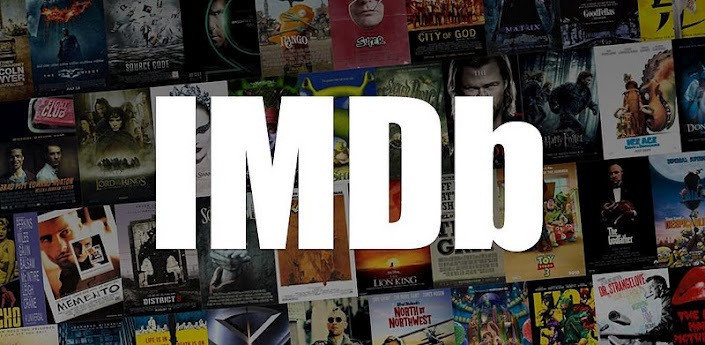

# Sentiment Analysis of IMDB Movie Reviews

The purpose of this project is analyzing the sentiment of IMDB movie reviews by implementing machine learning algorithms such asLogistic Regression, Naïve Bayes (NB) and Support Vector Machine (SVM).

## Importing Libraries

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator
from PIL import Image
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize.toktok import ToktokTokenizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,\
                            accuracy_score,roc_auc_score, roc_curve, auc


import warnings
warnings.filterwarnings('ignore')

In [2]:
#for ann
import tensorflow as tf

In [3]:
tf.__version__

'2.9.2'

In [4]:
#Downloding nltk stop word
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mohammadarifurrahman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
#set stopwords
stopwords_list = set(stopwords.words("english"))
more_stopwords = {'br', 'th', 'ti', 'di', 'dtype', 'one'}
stopwords_list = stopwords_list.union(more_stopwords)
stopwords_list.remove('not')

## Dataset

To get news and information about a movie people around the world usually rely on the IMDb website. Since IMDb is the most popular and universally used website which has a huge collection of movie reviews data, in our proposed work we used IMDb Movie Review Dataset for sentiment analysis on movie reviews.

In [6]:
#importing the data
imdb_data=pd.read_csv('IMDB Dataset.csv')
imdb_data.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [7]:
imdb_data.shape

(50000, 2)

In [8]:
imdb_data.describe()

review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000

In [10]:
imdb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


This dataset contains 50000 movie reviews which includes positive and negative reviews. All these raw reviews were collected from IMDb website. Next we will visually analyze our data set.

## Exploratory Data Analysis

### 1. Number of Reviews in each Sentiment Class 

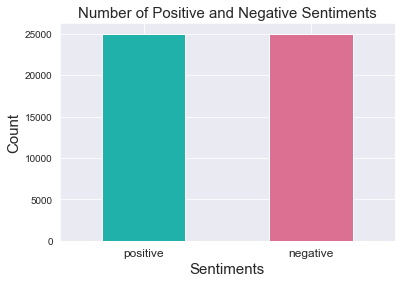

In [11]:
#sentiment count
sns.set_style('darkgrid')
imdb_data['sentiment'].value_counts().plot.bar(color=['lightseagreen', 'palevioletred'])
plt.xticks(rotation=0, fontsize=12)
plt.xlabel('Sentiments', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Number of Positive and Negative Sentiments', fontsize=15)
plt.show()

From the above plot we see, this data set is nicely balanced. We have 2500 reviews in each positive and negative side.

### 2. Number of words in reviews

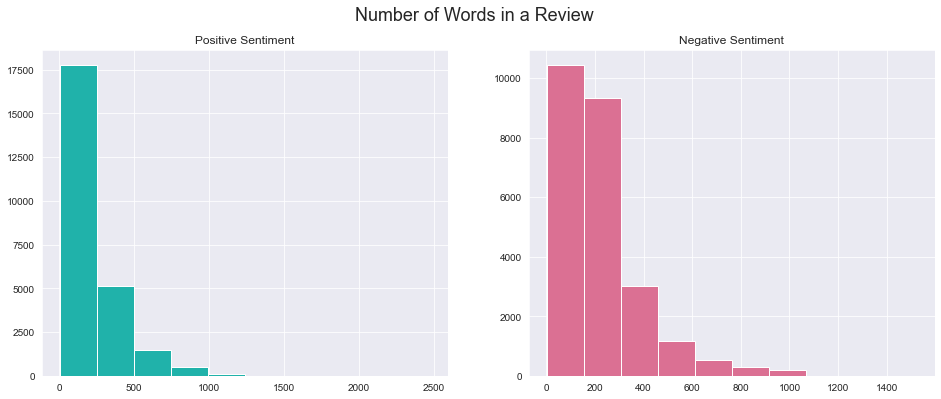

In [11]:
fig, ax = plt.subplots(1,2, figsize=(16,6))
review_pos = imdb_data[imdb_data['sentiment']=='positive']['review'].str.split().map(lambda x: len(x))
ax[0].hist(review_pos,color = 'lightseagreen')
ax[0].set_title('Positive Sentiment')

review_neg = imdb_data[imdb_data['sentiment']=='negative']['review'].str.split().map(lambda x: len(x))
ax[1].hist(review_neg,color = 'palevioletred')
ax[1].set_title('Negative Sentiment')
plt.suptitle('Number of Words in a Review', fontsize = 18)
plt.show()

Histogram show that positive reviews contain fewer words compare to negative reviews. This actually make sense because when people are not satisfiesd with the movies or products they paid for, they tends to write longer reviews.

### 3. Positive Vs Negative Sentiment words

In [12]:
def word_cloud_process(text,  width, height, background_color='black', max_words=400, 
                       max_font_size=400, mask=None):

    wordcloud = WordCloud(stopwords = stopwords_list, 
                          max_words = max_words,
                          max_font_size=max_font_size,
                          mask=mask, background_color=background_color,
                          width=width, height=height)
    
    return wordcloud.generate(str(text))   

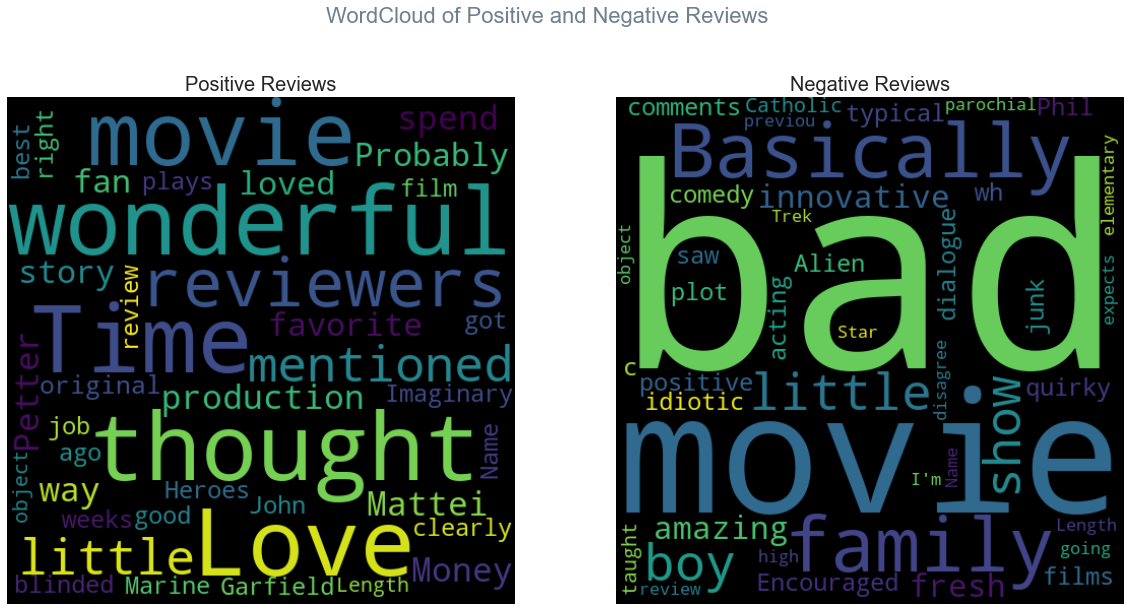

In [13]:
pos_rev = imdb_data[imdb_data['sentiment']=="positive"]['review']
neg_rev = imdb_data[imdb_data['sentiment']=="negative"]['review']

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))

ax1.imshow(word_cloud_process(pos_rev,width=500,height=500), interpolation='bilinear')
ax1.set_title('Positive Reviews', fontsize=20)
ax1.axis('off')

ax2.imshow(word_cloud_process(neg_rev,width=500,height=500), interpolation='bilinear')
ax2.set_title('Negative Reviews', fontsize=20)
ax2.axis('off')
plt.suptitle('WordCloud of Positive and Negative Reviews', fontsize=22, color='slategrey')

plt.show()

### From the word clouds above, we can say that
<br> 1) most frequent words used in positive reviews are Love, wonderful, Time, thought, loved etc. <br> 2) most frequent words used in negative reviews are bad, basically, junk, little, typical, family, etc.

### 4. Overall most common words

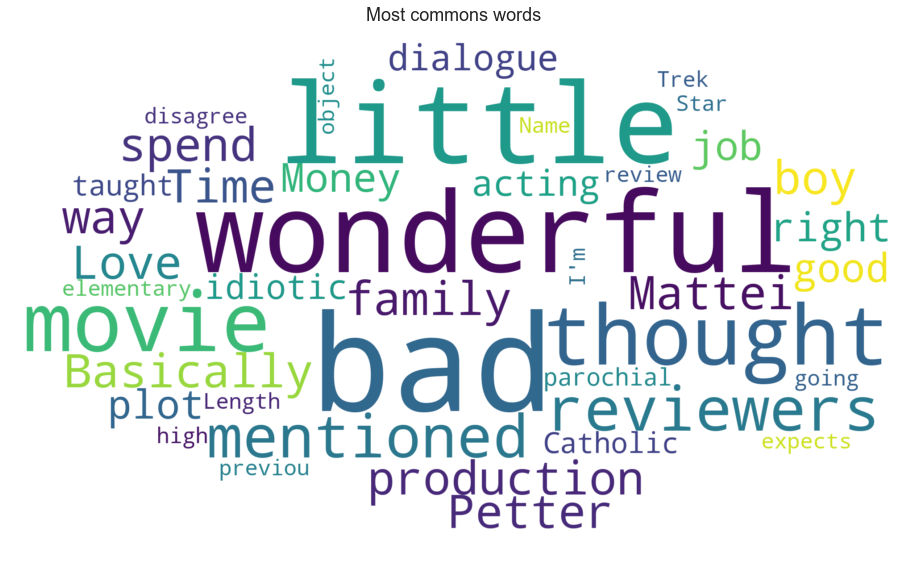

In [14]:
mask_all = np.array(Image.open('L3.png'))
plt.figure(figsize=(16,10))
plt.imshow(word_cloud_process(imdb_data['review'],1200,1000,background_color='white', 
                              max_font_size=300, mask=mask_all), 
           interpolation='bilinear')
plt.axis('off')
plt.title('Most commons words', fontsize=18)
plt.show()

## Data Preparation

It is important to preprocess the data before execution of any classification algorithm. Basic preprocessing is applied to each reviews of the dataset which involves of lowercasing, stemming and removing noise characters and stop words. The following data preparation techniques are applied: 
* Data Cleaning
    * url removal
    * special character removal
    * lowercasing
* Stop Words removal
    * Tokenization
* Stemming

In [15]:
#Step1
#Data cleaning
def data_cleaning(text_data): 
    remove_url = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',
                        text_data)
    remove_bracket = re.sub('\[[^]]*\]', '', remove_url)
    remove_special_characters = re.sub(r'[^a-zA-z\s]','', remove_bracket)
    return remove_special_characters.lower()

In [16]:
#Apply data cleaning function on review column
imdb_data['review']=imdb_data['review'].apply(data_cleaning)
imdb_data['review'].head()

0    one of the other reviewers has mentioned that ...
1    a wonderful little production br br the filmin...
2    i thought this was a wonderful way to spend ti...
3    basically theres a family where a little boy j...
4    petter matteis love in the time of money is a ...
Name: review, dtype: object

In [17]:
#Step2
#Stop words removal

#Tokenization of text
tokenizer=ToktokTokenizer()

#removing the stopwords
def stopwords_removal(text_data):
    tokens = tokenizer.tokenize(text_data)
    tokens = [token.strip() for token in tokens] 
    tokens_without_stopwords = [token for token in tokens if token not in stopwords_list]
    reviews_without_stopwords = ' '.join(tokens_without_stopwords)    
    return reviews_without_stopwords

In [20]:
#Apply stopwords removal on review column
imdb_data['review']=imdb_data['review'].apply(stopwords_removal)
imdb_data['review'].head()

0    one reviewers mentioned watching oz episode yo...
1    wonderful little production filming technique ...
2    thought wonderful way spend time hot summer we...
3    basically theres family little boy jake thinks...
4    petter matteis love time money visually stunni...
Name: review, dtype: object

In [21]:
#Step3
#Stemming the text
def stemming(text_data):
    porterStemmer = nltk.porter.PorterStemmer()
    reviews_after_stemming = ' '.join([porterStemmer.stem(word) for word in text_data.split()])
    return reviews_after_stemming

In [22]:
#Apply stemming on review column
imdb_data['review']=imdb_data['review'].apply(stemming)
imdb_data['review'].head()

0    one review mention watch oz episod youll hook ...
1    wonder littl product film techniqu unassum old...
2    thought wonder way spend time hot summer weeke...
3    basic there famili littl boy jake think there ...
4    petter mattei love time money visual stun film...
Name: review, dtype: object

In [57]:
# #just to avoid re run
# #saving cleaned file to pickel
# imdb_data['review'].to_pickle('cleaned_data.pickle')

In [9]:
cleaned_df = pd.read_pickle('/Users/mohammadarifurrahman/Projects/Movie Review 2/untitled folder/cleaned_data.pickle')
imdb_data['review'] = cleaned_df
#cleaned_df.head()

## Feature Extraction

The feature extraction or vectorization process is an important step for analyzing text which convert text into a matrix (or vector) of features. Since, the machine learning algorithms cannot work on the raw text directly, we need to use some feature extraction techniques that can transform the text data into numeric representations so that the data can be comprehensible by machine learning algorithms. In this project, we use 2 different feature extraction techniques:Bag of Words and TF-IDF with the combination of uni-gram and bi-gram.



In [10]:
def ngram_all(corpus, feature, nrange, n=None):
    if feature == 'bow':
        cv = CountVectorizer(ngram_range=nrange)
    elif feature == 'tfidf':
        cv = TfidfVectorizer(ngram_range=nrange)
    bag_of_words = cv.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    total_list = words_freq[:n]
    df = pd.DataFrame(total_list,columns=['text','count'])
    return df

In [20]:
uni_cv = ngram_all(imdb_data['review'], 'bow', (1,1), 10)
bi_cv = ngram_all(imdb_data['review'], 'bow', (2,2), 10)

uni_tfidf = ngram_all(imdb_data['review'], 'tfidf', (1,1), 10)
bi_tfidf = ngram_all(imdb_data['review'], 'tfidf', (2,2), 10)

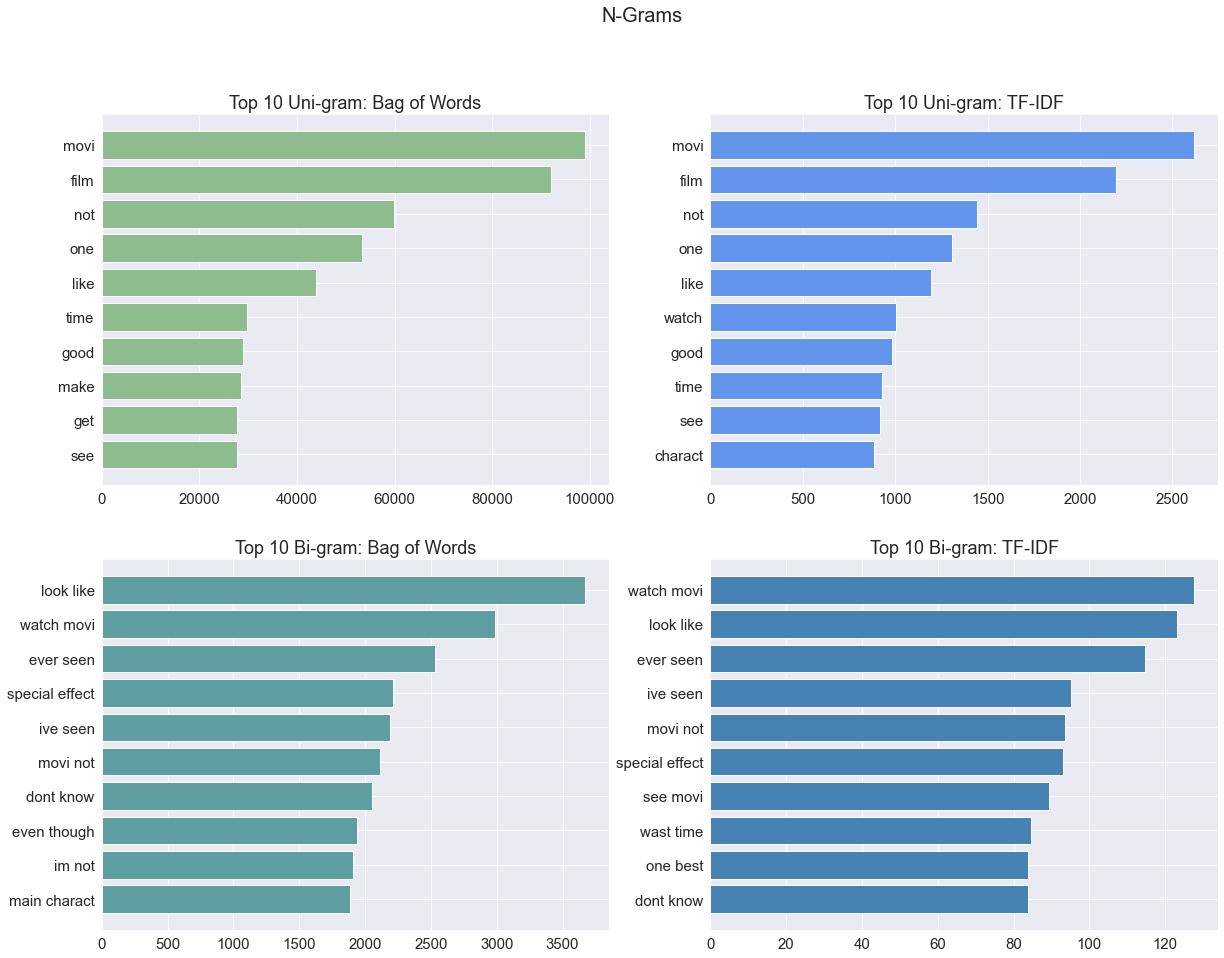

In [21]:
fig, ax = plt.subplots(2,2, figsize = (20,15))

ax[0,0].barh(y=uni_cv['text'][::-1], width=uni_cv['count'][::-1],color = 'darkseagreen')
ax[0,0].tick_params(labelsize=15)
ax[0,0].set_title('Top 10 Uni-gram: Bag of Words', fontsize=18)

ax[0,1].barh(y=uni_tfidf['text'][::-1], width=uni_tfidf['count'][::-1],color = 'cornflowerblue')
ax[0,1].tick_params(labelsize=15)
ax[0,1].set_title('Top 10 Uni-gram: TF-IDF', fontsize=18)

ax[1,0].barh(y=bi_cv['text'][::-1], width=bi_cv['count'][::-1],color = 'cadetblue')
ax[1,0].tick_params(labelsize=15)
ax[1,0].set_title('Top 10 Bi-gram: Bag of Words', fontsize=18)

ax[1,1].barh(y=bi_tfidf['text'][::-1], width=bi_tfidf['count'][::-1],color = 'steelblue')
ax[1,1].tick_params(labelsize=15)
ax[1,1].set_title('Top 10 Bi-gram: TF-IDF', fontsize=18)

plt.suptitle('N-Grams', fontsize=20)

plt.show()

## Modeling

Before moving into our NLP models first we will split the data set into 
* train (80 percent)
* test  (20 percent)

also we will change snetiments labels to 0 and 1.

In [11]:
# Split dataset into input and output

X = imdb_data['review']
y = imdb_data['sentiment']

In [12]:
y.unique()

array(['positive', 'negative'], dtype=object)

In [13]:
y

0        positive
1        positive
2        positive
3        negative
4        positive
           ...   
49995    positive
49996    negative
49997    negative
49998    negative
49999    negative
Name: sentiment, Length: 50000, dtype: object

In [14]:
#labeled the sentiments
y = y.replace({'negative':0, 'positive':1})
y

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64

In [15]:
X=X.values
y=y.values

Here we have changed the sentiments labels to 0 and 1 from 'negative' and 'positive'.

In [16]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In this project we spilt the 50000 movie reviews into to categories: train data and test data. First to train our model we selected 80 percent of data or 40000 reviews as train data. Then the rest 20 percent of the data or 10000 reviews are considered as test data to predict the sentiment in our proposed model.

## Classification Models

The main purpose of this project is the classification of reviews which is the process of assigning labels to the reviews whose label is unknown. Consequently, for this classification task we implemented Naïve Bayes classifier and SVM model to analyze the sentiment of the IMDB movie reviews.

In [17]:
def model_report_with_featureEX(model, feature_ex_method, ngram, X=X, X_train=X_train, 
                                X_test=X_test, y_train=y_train, y_test=y_test):
    
    #Feature Extraction
    if feature_ex_method == 'TFIDF':
        fv = TfidfVectorizer(ngram_range=ngram).fit(X)
        print('Feature Extraction Method is TF-IDF')
    elif feature_ex_method == 'BOW':
        fv = CountVectorizer(ngram_range=ngram).fit(X)
        print('Feature Extraction Method is BoW')
    else:
        fv = CountVectorizer(ngram_range=ngram).fit(X)
        print('Feature Extraction Method is BoW')
    
#     X_train_data = fv.transform(X_train).toarray()
#     X_test_data = fv.transform(X_test).toarray()
    
    X_train_data = fv.transform(X_train)
    X_test_data = fv.transform(X_test)
    
    
    #Modeling

    model_fit = model.fit(X_train_data, y_train)
    acc_score = model_fit.score(X_test_data, y_test)

    #ROC curve
    y_pred_proba = model_fit.predict_proba(X_test_data)[::,1]

    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
        
    predict = model_fit.predict(X_test_data)

    print(f'Ngram range: {ngram}')
    print(f'Accuracy: {acc_score*100:.2f}%')
    print('')

    report = classification_report(y_test, predict, target_names=['Negative', 'Positive'])
    print(report)
    
    return fpr, tpr, auc, X_train_data, X_test_data

### Logistic Regression

In [18]:
#Logistic regression Model
lr = LogisticRegression()

In [19]:
print('---- Logistic Regression:BoW with UniGram -------')
lr1 = model_report_with_featureEX(lr,'BOW', (1,1))

---- Logistic Regression:BoW with UniGram -------
Feature Extraction Method is BoW
Ngram range: (1, 1)
Accuracy: 87.53%

              precision    recall  f1-score   support

    Negative       0.88      0.87      0.88      5098
    Positive       0.87      0.88      0.87      4902

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [20]:
print('---- Logistic Regression:BoW with UniBiGram -------')
lr2 = model_report_with_featureEX(lr,'BOW', (1,2))

---- Logistic Regression:BoW with UniBiGram -------
Feature Extraction Method is BoW
Ngram range: (1, 2)
Accuracy: 89.27%

              precision    recall  f1-score   support

    Negative       0.90      0.89      0.89      5098
    Positive       0.89      0.90      0.89      4902

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [21]:
print('---- Logistic Regression:TFIDF with UniGram -------')
lr3 = model_report_with_featureEX(lr,'TFIDF', (1,1))

---- Logistic Regression:TFIDF with UniGram -------
Feature Extraction Method is TF-IDF
Ngram range: (1, 1)
Accuracy: 88.58%

              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      5098
    Positive       0.88      0.89      0.88      4902

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [22]:
print('---- Logistic Regression:TFIDF with UniBiGram -------')
lr4 = model_report_with_featureEX(lr,'TFIDF', (1,2))

---- Logistic Regression:TFIDF with UniBiGram -------
Feature Extraction Method is TF-IDF
Ngram range: (1, 2)
Accuracy: 88.36%

              precision    recall  f1-score   support

    Negative       0.90      0.87      0.88      5098
    Positive       0.87      0.90      0.88      4902

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



### Naïve Bayes Classifier

In [23]:
#Naive Bayes Model
mnb=MultinomialNB()

In [24]:
print('---- Naive Bayes:BoW with UniGram -------')
nb1 = model_report_with_featureEX(mnb,'BOW', (1,1))

---- Naive Bayes:BoW with UniGram -------
Feature Extraction Method is BoW
Ngram range: (1, 1)
Accuracy: 84.73%

              precision    recall  f1-score   support

    Negative       0.84      0.87      0.85      5098
    Positive       0.86      0.83      0.84      4902

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [25]:
print('---- Naive Bayes:BoW with UniBiGram -------')
nb2 = model_report_with_featureEX(mnb,'BOW', (1,2))

---- Naive Bayes:BoW with UniBiGram -------
Feature Extraction Method is BoW
Ngram range: (1, 2)
Accuracy: 87.87%

              precision    recall  f1-score   support

    Negative       0.87      0.90      0.88      5098
    Positive       0.89      0.86      0.87      4902

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [26]:
print('---- Naive Bayes:TFIDF with UniGram -------')
nb3 = model_report_with_featureEX(mnb,'TFIDF', (1,1))

---- Naive Bayes:TFIDF with UniGram -------
Feature Extraction Method is TF-IDF
Ngram range: (1, 1)
Accuracy: 85.37%

              precision    recall  f1-score   support

    Negative       0.85      0.86      0.86      5098
    Positive       0.86      0.84      0.85      4902

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [27]:
print('---- Naive Bayes:TFIDF with UniBiGram -------')
nb4 = model_report_with_featureEX(mnb,'TFIDF', (1,2))

---- Naive Bayes:TFIDF with UniBiGram -------
Feature Extraction Method is TF-IDF
Ngram range: (1, 2)
Accuracy: 88.33%

              precision    recall  f1-score   support

    Negative       0.89      0.89      0.89      5098
    Positive       0.88      0.88      0.88      4902

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



### SVM Classifier

In [28]:
#instantiate the model
svc = LinearSVC(dual=False) 
SVM = CalibratedClassifierCV(svc) 


In [29]:
print('---- SVM:BoW with UniGram -------')
svm1 = model_report_with_featureEX(SVM,'BOW', (1,1))

---- SVM:BoW with UniGram -------
Feature Extraction Method is BoW
Ngram range: (1, 1)
Accuracy: 86.88%

              precision    recall  f1-score   support

    Negative       0.88      0.86      0.87      5098
    Positive       0.86      0.88      0.87      4902

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [30]:
print('---- SVM:BoW with UniBiGram -------')
svm2 = model_report_with_featureEX(SVM,'BOW', (1,2))

---- SVM:BoW with UniBiGram -------
Feature Extraction Method is BoW
Ngram range: (1, 2)
Accuracy: 88.86%

              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      5098
    Positive       0.88      0.89      0.89      4902

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [31]:
print('---- SVM:TFIDF with UniGram -------')
svm3 = model_report_with_featureEX(SVM,'TFIDF', (1,1))

---- SVM:TFIDF with UniGram -------
Feature Extraction Method is TF-IDF
Ngram range: (1, 1)
Accuracy: 88.74%

              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      5098
    Positive       0.88      0.89      0.89      4902

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [32]:
print('---- SVM:TFIDF with UniBiGram -------')
svm4 = model_report_with_featureEX(SVM,'TFIDF', (1,2))

---- SVM:TFIDF with UniBiGram -------
Feature Extraction Method is TF-IDF
Ngram range: (1, 2)
Accuracy: 90.03%

              precision    recall  f1-score   support

    Negative       0.90      0.90      0.90      5098
    Positive       0.90      0.90      0.90      4902

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [33]:
# svm4[4].toarray()

### Random Forest

In [34]:
rf = RandomForestClassifier()

In [35]:
print('---- random forest:BoW with UniGram -------')
rf1 = model_report_with_featureEX(rf,'BOW', (1,1))

---- random forest:BoW with UniGram -------
Feature Extraction Method is BoW
Ngram range: (1, 1)
Accuracy: 84.69%

              precision    recall  f1-score   support

    Negative       0.85      0.85      0.85      5098
    Positive       0.84      0.84      0.84      4902

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [36]:
print('---- random forest:BoW with UniBiGram -------')
rf2 = model_report_with_featureEX(rf,'BOW', (1,2))

---- random forest:BoW with UniBiGram -------
Feature Extraction Method is BoW
Ngram range: (1, 2)
Accuracy: 85.29%

              precision    recall  f1-score   support

    Negative       0.87      0.84      0.85      5098
    Positive       0.84      0.87      0.85      4902

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [37]:
print('---- random forest:TFIDF with UniGram -------')
rf3 = model_report_with_featureEX(rf,'TFIDF', (1,1))

---- random forest:TFIDF with UniGram -------
Feature Extraction Method is TF-IDF
Ngram range: (1, 1)
Accuracy: 84.22%

              precision    recall  f1-score   support

    Negative       0.85      0.84      0.85      5098
    Positive       0.84      0.84      0.84      4902

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [38]:
print('---- random forest:TFIDF with UniBiGram -------')
rf4 = model_report_with_featureEX(rf,'TFIDF', (1,2))

---- random forest:TFIDF with UniBiGram -------
Feature Extraction Method is TF-IDF
Ngram range: (1, 2)
Accuracy: 85.36%

              precision    recall  f1-score   support

    Negative       0.87      0.84      0.85      5098
    Positive       0.84      0.87      0.85      4902

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [39]:
# print('---- random forest:BoW with UniGram -------')
# rf1 = model_report_with_featureEX(rf,'BOW', (1,1))

# print('---- random forest:BoW with UniBiGram -------')
# rf2 = model_report_with_featureEX(rf,'BOW', (1,2))

# print('---- random forest:TFIDF with UniGram -------')
# rf3 = model_report_with_featureEX(rf,'TFIDF', (1,1))

# print('---- random forest:TFIDF with UniBiGram -------')
# rf4 = model_report_with_featureEX(rf,'TFIDF', (1,2))


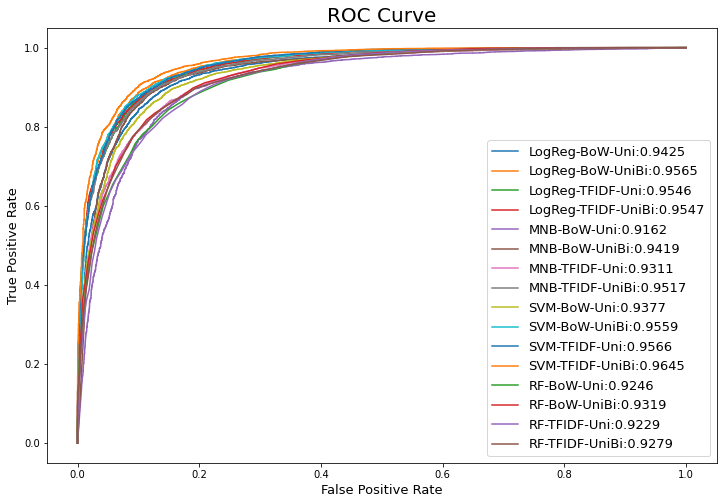

In [40]:
plt_list = [lr1, lr2, lr3, lr4, nb1, nb2, nb3, nb4, 
            svm1, svm2, svm3, svm4, rf1, rf2, rf3, rf4]
model_name = ['LogReg-BoW-Uni', 'LogReg-BoW-UniBi', 'LogReg-TFIDF-Uni', 'LogReg-TFIDF-UniBi',
             'MNB-BoW-Uni', 'MNB-BoW-UniBi', 'MNB-TFIDF-Uni', 'MNB-TFIDF-UniBi',
              'SVM-BoW-Uni', 'SVM-BoW-UniBi', 'SVM-TFIDF-Uni', 'SVM-TFIDF-UniBi',
             'RF-BoW-Uni', 'RF-BoW-UniBi', 'RF-TFIDF-Uni', 'RF-TFIDF-UniBi']

plt.figure(figsize=(12,8))
for models, label in zip(plt_list, model_name):
    
    plt.plot(models[0], models[1], label=f'{label}:'+str(f'{models[2]:.4f}'))
    plt.legend(loc=4, fontsize=13)
    
plt.ylabel('True Positive Rate', fontsize=13)
plt.xlabel('False Positive Rate', fontsize=13)
plt.title('ROC Curve', fontsize=20)
plt.show()

In [44]:
from xgboost import XGBClassifier

In [47]:
xgb = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)

In [48]:
print('---- XGB:TFIDF with UniBiGram -------')
xgb4 = model_report_with_featureEX(xgb,'TFIDF', (1,2))

---- XGB:TFIDF with UniBiGram -------
Feature Extraction Method is TF-IDF
[03:08:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Ngram range: (1, 2)
Accuracy: 85.71%

              precision    recall  f1-score   support

    Negative       0.87      0.85      0.86      5098
    Positive       0.85      0.86      0.86      4902

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [50]:
# definition of parameter grid to scan through
param_grid = {
     'clf__n_estimators': [50,100,300]
#    'clf__colsample_bytree': [0.6,0.8,1]
#    'clf__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

In [51]:
# grid search cross validation instantiation
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                          cv = 3, n_jobs = 1, verbose = 0, return_train_score=True)

In [52]:
#hyperparameter fitting
grid_search.fit(xgb4[3], y_train)

[03:14:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:576: 
Parameters: { "clf__n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:14:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:15:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:576: 
Parameters: { "clf__n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.6,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=-1, importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=8,
                                     num_parallel_tree=1, predictor='auto',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=2, subsample=0.7,
                                     tree_method='exact', validate_parameters=1,
                                     verbosity=None),
             n_jobs=1, param_grid={'clf__n_estimators': [50, 100, 300]},
             return_train_score=True)

In [53]:
grid_search.cv_results_['mean_train_score']

array([0.93718752, 0.93718752, 0.93718752])

In [54]:
grid_search.cv_results_['mean_test_score']

array([0.85442499, 0.85442499, 0.85442499])

In [55]:
grid_search.best_params_

{'clf__n_estimators': 50}

### ANN

In [22]:
from keras.preprocessing import text, sequence
from keras import utils
from keras.optimizers import SGD

In [23]:
# tokenize input 
max_words = 20000
tokenize = text.Tokenizer(num_words = max_words, char_level=False)
#tokenize = text.Tokenizer(char_level=False)
tokenize.fit_on_texts(X_train)

X_train_ann = tokenize.texts_to_matrix(X_train, mode='tfidf')
X_test_ann = tokenize.texts_to_matrix(X_test, mode='tfidf')

In [24]:
X_train_ann.shape

(40000, 20000)

In [25]:
#converting to matrix
num_classes = np.max(y_train) + 1
y_train_ann = utils.to_categorical(y_train, num_classes)
y_test_ann = utils.to_categorical(y_test, num_classes)

In [26]:
#Building the ANN

#Initializing the ANN
ann = tf.keras.models.Sequential()
#adding first hidden layer
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
#adding second layer
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
#adding output layer
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

Metal device set to: Apple M1


2022-07-22 12:52:37.680601: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-22 12:52:37.680830: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [27]:
batch_size = 32
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.8, decay=decay)

In [28]:
#compiling the ANN
ann.compile(optimizer = 'adam', 
            #optimizer = sgd,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [29]:
#Training the ANN
ann.fit(X_train_ann, y_train.values, batch_size=32, epochs=25)

Epoch 1/25


2022-07-22 12:52:47.269403: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  12/1250 [..............................] - ETA: 5s - loss: 0.6971 - accuracy: 0.5260  

2022-07-22 12:52:47.536067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 6s 4ms/step - loss: 0.3323 - accuracy: 0.8656
Epoch 2/25
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1572 - accuracy: 0.9418
Epoch 3/25
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0991 - accuracy: 0.9602
Epoch 4/25
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0660 - accuracy: 0.9734
Epoch 5/25
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0493 - accuracy: 0.9813
Epoch 6/25
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0334 - accuracy: 0.9874
Epoch 7/25
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0216 - accuracy: 0.9923
Epoch 8/25
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0178 - accuracy: 0.9936
Epoch 9/25
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0164 - accuracy: 0.9938
Epoch 10/25
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0141 - accurac

### SHAP Model Explainability

In [33]:
import shap

In [36]:
vect = TfidfVectorizer(ngram_range=(1,2))
vect.fit(X.values)
feature_names = vect.get_feature_names_out()

In [37]:
feature_names

array(['__', '__ actual', '__ ye', ...,
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz oh',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz'], dtype=object)

In [ ]:
explainer = shap.KernelExplainer(SVM.predict_proba, svm4[3].toarray(), feature_names=feature_names)
shap_values = explainer(svm4[4].toarray())
print(shap_values.values.shape) 

In [20]:
import shap
# Initialize in notebook environment
shap.initjs()
# Define the explainer for the built model
explainer = shap.KernelExplainer(SVM.predict_proba, svm4[3])
# obtain shap values for the first row of the test data
shap_values = explainer.shap_values(X_test.iloc[0])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[0])

### Lime

In [94]:
# for LIME import necessary packages
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from lime.lime_text import explanation
from sklearn.pipeline import make_pipeline


In [79]:
# Explaining the predictions and important features for predicting the label 1
tfidf = TfidfVectorizer(ngram_range=(1,2)).fit(X)
pipe = make_pipeline(tfidf, SVM)

In [103]:
class_names = ['negative', 'positive']
explainer = LimeTextExplainer(class_names=class_names)

In [104]:
idx = 11
exp = explainer.explain_instance(X_test[idx], pipe.predict_proba, 
                                 num_features=20,labels=(1,))

In [105]:
print(exp.available_labels())

[1]


In [109]:
display_data=pd.read_csv('IMDB Dataset.csv')
X_dis = imdb_data['review'].values
y_dis = imdb_data['sentiment'].values

In [106]:
exp.show_in_notebook(text=X_test[idx])

In [116]:
idx = 1
exp = explainer.explain_instance(X_test[idx], pipe.predict_proba, 
                                 num_features=20,labels=(1,))

exp.show_in_notebook(text=X_test[idx])

In [117]:
X_test[idx], y_test[idx]

('spoiler alert work extra lifetim tv movi film seattl realli interest take part product movi usual still process either still write part case make edit cut major chang final partsbr husband work extra movi recal discuss set yet determin whether not littl girl die end frankli never thought margaret colin charact realli got adequ punish crime hit run lie polic cover etc could imagin end would chang end kill hit run victim instead end come coma okay someth think aboutbr way play polic detect see split second husband play anoth detect see quit often weve count four time margaret colin great work earth although lisa vidal lifetim regular aloofbr overal movi turn like anoth poster comment still real tearjerk make great saturday afternoon cabl flick',
 1)

In [115]:
y_test

array([0, 1, 0, ..., 1, 1, 1])

## Conclusion

In conclusion, by comparing the performance results of Logistic Regression, Naïve Bayes, and SVM for unigram and combination of unigram and bigram, it is clear that the SVM classifier with TF-IDF unigram bigram mixture technique (accracy 90%, AUC: 0.96) outperformed all the other approaches.